<a href="https://colab.research.google.com/github/DE-Karpov/comaru/blob/develop/comaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install apyori

!pip install pyfpgrowth

!pip install  -U mlxtend

  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=ae40ee4330af650bc0f2d9f970c7162a2112d6e42009062fa7fc5f2a2ecf044d
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
     |████████████████████████████████| 1.6MB 12.6MB/s 
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5477 sha256=77e279b490ca5cc617741a00238018f0386e628b8bbd7174c85ab747140b55bd
  Stored in directory: /root/.cache/pip/wheels/3b/3f/0d/a04bb8b17887c1eca7d0f1a48d4aa0c09c96eb221ff7fa56c1
Successfully built pyfpgrowth
     |████████████████████████████████| 1.4MB 13.1MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
from apyori import apriori
from google.colab import files
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori as mapriori
from mlxtend.frequent_patterns import fpgrowth 
from mlxtend.frequent_patterns import fpmax 
from mlxtend.frequent_patterns import association_rules 
import pyfpgrowth
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
uploaded = files.upload()

Saving retail_dataset.csv to retail_dataset.csv


In [4]:
class AssocRules:

    def __init__(self):
        self.dataset = pd.read_csv("retail_dataset.csv")
        self.transactions = []
        self.fill_transactions()

    def fill_transactions(self):
        for i in range(0, 315): 
            self.transactions.append([str(self.dataset.values[i,j]) for j in range(0, 6) if not pd.isnull(self.dataset.values[i,j])])    

    class Eclat:

        def __init__(self, min_support = 0.01, max_items = 5, min_items = 2):
            self.min_support = min_support
            self.max_items = max_items
            self.min_items = min_items
            self.item_lst = list()
            self.item_len = 0
            self.item_dict = dict()
            self.final_dict = dict()
            self.data_size = 0
        
        def read_data(self, dataset):
            for index, row in dataset.iterrows():
                row_wo_na = set(row)
                for item in row_wo_na:
                    if pd.isnull(item):
                        continue
                    else:
                        item = item.strip()
                    if item in self.item_dict:
                        self.item_dict[item][0] += 1
                    else:
                        self.item_dict.setdefault(item, []).append(1)
                    self.item_dict[item].append(index)

            self.data_size = dataset.shape[0]
            self.item_lst = list(self.item_dict.keys())
            self.item_len = len(self.item_lst)
            self.min_support = self.min_support * self.data_size
            
        def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
            if tids_array[0] >= minsupp and num_items <= self.max_items:
                for k in range(k_start+1, self.item_len):
                    if self.item_dict[self.item_lst[k]][0] >= minsupp:
                        new_item = item_name + "|" + self.item_lst[k]
                        new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                        new_tids_size = new_tids.size
                        new_tids = np.insert(new_tids, 0, new_tids_size)
                        if new_tids_size >= minsupp:
                            if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                            self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
        
        def fit(self, dataset):
            i = 0
            self.read_data(dataset)
            for w in self.item_lst:
                self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
                i+=1
            return self
            
        def transform(self):
            return [k[0].split("|") for k in self.final_dict.items()]


    def get_apriori(self, params):
      rules = list(apriori(self.transactions, min_support = params["min_support"], min_confidence = params["min_confidence"], min_lift = params["min_lift"], max_length = params["max_length"]))
      list_of_rules = [list(record.items) for record in rules]
      return list_of_rules

    def get_eclat(self, params):
      model = AssocRules.Eclat(min_support = params["min_support"], max_items = params["max_length"], min_items = 1)
      model.fit(self.dataset)
      return model.transform()

    def get_fpgrowth(self, params):
      support_threshold = int(len(self.transactions) * params['min_support'])
      patterns = pyfpgrowth.find_frequent_patterns(self.transactions, support_threshold)
      new_patterns = {k: v for k, v in patterns.items() if not (("nan") in k)}
      unprepared_list = list(pyfpgrowth.generate_association_rules(new_patterns, params["min_confidence"]))
      prepared_list = [list(item) for item in unprepared_list if len(item) == 2 ]
      return prepared_list

    def user_input_features(self):
      min_support = st.sidebar.slider("Minimal support", 0.01, 0.03, 0.001)
      min_confidence = st.sidebar.slider("Min confidence", 0.2, 0.6, 0.1)
      min_lift = st.sidebar.slider("Lift", 0.5, 6.0, 1.0)
      min_length = st.sidebar.slider("Min length", 1, 2, 3)
      data = {"min_support": min_support,
              "min_confidence": min_confidence,
              "min_lift": min_lift,
              "min_length": min_length}
      features = pd.DataFrame(data, index=[0])
      return features

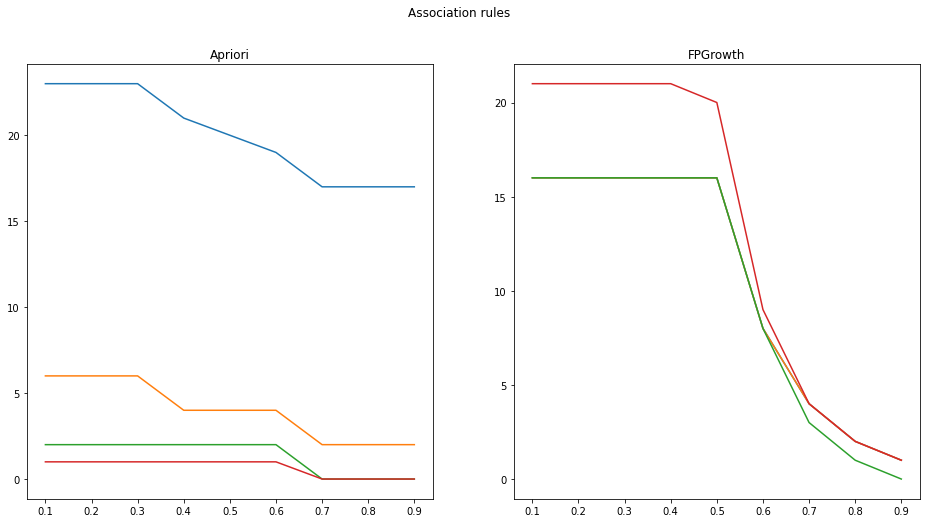

In [5]:
rules = AssocRules()

confidence = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def gen_rules(min_support, min_lift = 2.0, max_length = None, alg = 'apriori'):
    ap = {}
    common_rules = []
    if alg == 'apriori':
      for i in confidence:
        parameters = {"min_support" : min_support, "min_confidence" : i, "min_lift" : min_lift, "max_length" : max_length}
        apriori_rules = rules.get_apriori(parameters)
        ap[i] = len(apriori_rules)
        common_rules.append(apriori_rules)
    elif alg == 'fpgrowth':
      for i in confidence:
        parameters = {"min_support" : min_support, "min_confidence" : i}
        fpgrowth_rules = rules.get_fpgrowth(parameters)
        ap[i] = len(fpgrowth_rules)
        common_rules.append(fpgrowth_rules)
    return pd.Series(ap).to_frame("Support: %s"%min_support), common_rules

apriori_plot = []
fpgrowth_plot = []
common_rules_plot = []
for i in [0.005,0.01,0.05,0.1]:
    apriori_alg = gen_rules(min_support = i)
    fpgrowth_alg = gen_rules(min_support = i, alg='fpgrowth')
    apriori_plot.append(apriori_alg[0])
    fpgrowth_plot.append(fpgrowth_alg[0])

apriori_all_conf = pd.concat(apriori_plot, axis=1)
fpgrowth_all_conf = pd.concat(fpgrowth_plot, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
fig.suptitle('Association rules')
ax1.set_title('Apriori')
ax2.set_title('FPGrowth')
ax1.plot(apriori_all_conf)
ax2.plot(fpgrowth_all_conf)

In [6]:
def createOneHotVec(df):
  items = (df['0'].unique())
  itemset = set(items)
  encoded_vals = []
  for index, row in df.iterrows():
      rowset = set(row) 
      labels = {}
      uncommons = list(itemset - rowset)
      commons = list(itemset.intersection(rowset))
      for uc in uncommons:
          labels[uc] = 0
      for com in commons:
          labels[com] = 1
      encoded_vals.append(labels)
  encoded_vals[0]
  ohe_df = pd.DataFrame(encoded_vals)
  return ohe_df

In [7]:
def getAprioriRules(df):
  ohe_df = createOneHotVec(df)
  freq_items = mapriori(ohe_df, min_support = 0.1, use_colnames = True)
  assoc_rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.1)
  return assoc_rules

In [8]:
def getFPGrowthRules(df):
  ohe_df = createOneHotVec(df)
  freq_items = fpgrowth(ohe_df, min_support = 0.1, use_colnames = True, verbose = 1)
  assoc_rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.1)
  return assoc_rules

In [9]:
def getFPMaxRules(df):
  ohe_df = createOneHotVec(df)
  freq_items = fpmax(ohe_df, min_support = 0.1, use_colnames = True, verbose = 1)
  assoc_rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.1, support_only = True)
  return assoc_rules

In [10]:
def getECLATRules(df):
  ohe_df = createOneHotVec(df)
  parameters = {"min_support" : 0.1, "max_length" : 3}
  assoc_rules = rules.get_eclat(params = parameters)
  return assoc_rules

In [11]:
new_rules = rules.dataset

In [12]:
t0 = time.clock()
getAprioriRules(new_rules)
t1 = time.clock() - t0
print("Apriori time: ", t1) # CPU seconds elapsed (floating point)

Apriori time:  0.07482999999999951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
t0 = time.clock()
getFPGrowthRules(new_rules)
t1 = time.clock() - t0
print("FPGrowth time: ", t1) # CPU seconds elapsed (floating point)

9 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (Bread)
1 itemset(s) from tree conditioned on items (Cheese)
3 itemset(s) from tree conditioned on items (Meat)
0 itemset(s) from tree conditioned on items (Meat, Cheese)
2 itemset(s) from tree conditioned on items (Meat, Bread)
0 itemset(s) from tree conditioned on items (Meat, Bread, Cheese)
0 itemset(s) from tree conditioned on items (Meat, Bread, Milk)
1 itemset(s) from tree conditioned on items (Meat, Milk)
4 itemset(s) from tree conditioned on items (Eggs)
0 itemset(s) from tree conditioned on items (Eggs, Cheese)
1 itemset(s) from tree conditioned on items (Eggs, Meat)
2 itemset(s) from tree conditioned on items (Eggs, Bread)
0 itemset(s) from tree conditioned on items (Eggs, Bread, Cheese)
0 itemset(s) from tree conditioned on items (Eggs, Bread, Milk)
2 itemset(s) from tree conditioned on items (Eggs, Milk)
0 itemset(s) from tree conditioned on items (Eggs, Milk, Cheese)
1 itemset(s) fro

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
t0 = time.clock()
getFPMaxRules(new_rules)
t1 = time.clock() - t0
print("FPMax time: ", t1) # CPU seconds elapsed (floating point)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


0 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (Pencil)
1 itemset(s) from tree conditioned on items (Pencil, Bagel)
0 itemset(s) from tree conditioned on items (Pencil, Eggs)
1 itemset(s) from tree conditioned on items (Pencil, Eggs, Cheese)
1 itemset(s) from tree conditioned on items (Pencil, Eggs, Wine)
0 itemset(s) from tree conditioned on items (Pencil, Diaper)
1 itemset(s) from tree conditioned on items (Pencil, Diaper, Bread)
1 itemset(s) from tree conditioned on items (Pencil, Diaper, Wine)
0 itemset(s) from tree conditioned on items (Pencil, Milk)
1 itemset(s) from tree conditioned on items (Pencil, Milk, Cheese)
1 itemset(s) from tree conditioned on items (Pencil, Milk, Bread)
0 itemset(s) from tree conditioned on items (Pencil, Meat)
1 itemset(s) from tree conditioned on items (Pencil, Meat, Cheese)
1 itemset(s) from tree conditioned on items (Pencil, Meat, Bread)
1 itemset(s) from tree conditioned on items (Pencil, Meat, Wine)
0 it

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
t0 = time.clock()
getECLATRules(new_rules)
t1 = time.clock() - t0
print("ECLAT time: ", t1) # CPU seconds elapsed (floating point)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


ECLAT time:  0.08846299999999996


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
def getCommonRules(leftRules, rightRules):
  commonRules = []
  for leftSubList in leftRules:
    leftSubList = sorted(leftSubList)
    for rightSubList in rightRules:
      if leftSubList == rightSubList:
        if leftSubList not in commonRules:
          commonRules.append(leftSubList)
  
  return commonRules

In [60]:
import itertools

def getAllRules(leftRules, rightRules):
  wholeRules = []
  new_left_rules = []
  new_right_rules = []
  for leftSubList in leftRules:
    new_left_rules.append(sorted(leftSubList))
  left_rules = list(new_left_rules for new_left_rules,_ in itertools.groupby(new_left_rules))
  
  wholeRules = left_rules

  for rightSubList in rightRules:
    new_right_rules.append(sorted(rightSubList))  
  right_rules = list(new_right_rules for new_right_rules,_ in itertools.groupby(new_right_rules))

  for rightSubList in right_rules:
    if rightSubList not in wholeRules:
      wholeRules.append(rightSubList)
  
  wholeRules = sorted(wholeRules)
  return wholeRules

In [18]:
def transform(df):
  list_of_rules = []
  for item in df:
    intermediate_rules = []
    intermediate_rules.append(next(iter(item[0])))
    intermediate_rules.append(next(iter(item[1])))
    list_of_rules.append(intermediate_rules)
  return list_of_rules

In [61]:
prepared_apriori_data = transform(getAprioriRules(new_rules).reset_index()[['antecedents', 'consequents']].values.tolist())
prepared_fpgrowth_data = transform(getFPGrowthRules(new_rules).reset_index()[['antecedents', 'consequents']].values.tolist())
prepared_fpmax_data = transform(getFPMaxRules(new_rules).reset_index()[['antecedents', 'consequents']].values.tolist())
prepared_eclat_data = getECLATRules(new_rules)

common_rules_app_growth = getCommonRules(prepared_apriori_data, prepared_fpgrowth_data)
common_rules_max_eclat = getCommonRules(prepared_fpmax_data, prepared_eclat_data)
common_rules = getCommonRules(common_rules_app_growth, common_rules_max_eclat)

all_rules_app_growth = getAllRules(prepared_apriori_data, prepared_fpgrowth_data)
all_rules_max_eclat = getAllRules(prepared_fpmax_data, prepared_eclat_data)
all_rules = getAllRules(all_rules_app_growth, all_rules_max_eclat)

9 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (Bread)
1 itemset(s) from tree conditioned on items (Cheese)
3 itemset(s) from tree conditioned on items (Meat)
0 itemset(s) from tree conditioned on items (Meat, Cheese)
2 itemset(s) from tree conditioned on items (Meat, Bread)
0 itemset(s) from tree conditioned on items (Meat, Bread, Cheese)
0 itemset(s) from tree conditioned on items (Meat, Bread, Milk)
1 itemset(s) from tree conditioned on items (Meat, Milk)
4 itemset(s) from tree conditioned on items (Eggs)
0 itemset(s) from tree conditioned on items (Eggs, Cheese)
1 itemset(s) from tree conditioned on items (Eggs, Meat)
2 itemset(s) from tree conditioned on items (Eggs, Bread)
0 itemset(s) from tree conditioned on items (Eggs, Bread, Cheese)
0 itemset(s) from tree conditioned on items (Eggs, Bread, Milk)
2 itemset(s) from tree conditioned on items (Eggs, Milk)
0 itemset(s) from tree conditioned on items (Eggs, Milk, Cheese)
1 itemset(s) fro

In [63]:
len(common_rules)

13

In [64]:
len(all_rules)

87